In this file I analysis fMRI data with sgm-fMRI.


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap
from sgm_fMRI.sgm import sgm_fMRI

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
import logging

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        ttest_res1 = mannwhitneyu(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
        tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    ttest_res1 = mannwhitneyu(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}Dementia vs HC", 
                f"{ttest_res1.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
SC_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"];

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


# Run SGM

In [8]:
sgm = sgm_fMRI(SC_mat);

In [9]:
def _run_fn(sub_ix):
    ts = _load_data(sub_ix);
    ts = _preprocess_ts(ts)[:num_rois];
    sgm.add_data(ts.T, model_focus="both")
    sgm.fit()
    
    # save for the results
    res = edict()
    res.fitted_theta = sgm.fitted_theta
    res.model_fc = sgm.forward_FC()
    res.model_psd = sgm.forward_FX()
    res.fit_res = sgm.fit_res
    return res

with Parallel(n_jobs=5) as parallel:
    ress = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:35<00:00,  9.08it/s]


In [10]:
save_pkl(RES_ROOT/"sgm_all_res.pkl", ress);

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/sgm_all_res.pkl


# Analysis

In [13]:
from scipy.stats import f_oneway, ttest_ind 
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

In [50]:
data_len = np.array([  _load_data(sub_ix).shape[1] for sub_ix in range(1, 322)]);
df = pd.DataFrame({"data_len":data_len, 
                   "diag_labs": diag_labs});
df["data_len_ix"] = df["data_len"].map(lambda x: int(x==235));
df.groupby("diag_labs")["data_len_ix"].describe()[["count", "mean"]]

,count,mean
diag_labs,,
1,82.0,0.353659
2,41.0,0.463415
3,27.0,0.629630
4,34.0,0.735294
5,37.0,0.810811
6,100.0,0.530000


In [14]:
ress = load_pkl(RES_ROOT/"sgm_all_res.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/sgm_all_res.pkl


In [20]:
ress[0].keys()

dict_keys(['fitted_theta', 'model_fc', 'model_psd', 'fit_res'])

## Theta

[alpha, tau]

Alpha (coupling constant?)
+-----------------------------+--------+-------------+
|                        Test |  Pval  | Effect size |
+-----------------------------+--------+-------------+
|                    AD vs HC |  0.092 |     0.251   |
|       (non-param) *AD vs HC |  0.038 |     0.251   |
|                 bvFTD vs HC |  0.193 |     0.241   |
|     (non-param) bvFTD vs HC |  0.308 |     0.241   |
|                  *CBS vs HC |  0.044 |     0.434   |
|      (non-param) *CBS vs HC |  0.013 |     0.434   |
|                nfvPPA vs HC |  0.105 |     0.321   |
|   (non-param) *nfvPPA vs HC |  0.050 |     0.321   |
|                 svPPA vs HC |  0.260 |     0.217   |
|     (non-param) svPPA vs HC |  0.162 |     0.217   |
|             *Dementia vs HC |  0.030 |     0.261   |
| (non-param) *Dementia vs HC |  0.008 |     0.261   |
|                       ANOVA |  0.355 |             |
+-----------------------------+--------+-------------+


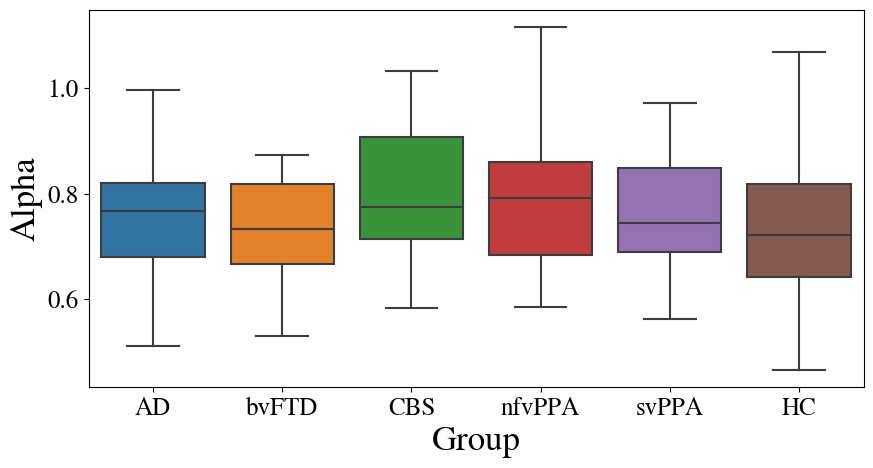

In [28]:
metric = "Alpha"
metrics = np.array([res["fitted_theta"][0] for res in ress])
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric", showfliers=False)
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"{metric} (coupling constant?)")
print(_get_test_tb(res_df))

Tau (time constant?)
+-----------------------------+--------+-------------+
|                        Test |  Pval  | Effect size |
+-----------------------------+--------+-------------+
|                   *AD vs HC |  0.014 |    -0.363   |
|       (non-param) *AD vs HC |  0.006 |    -0.363   |
|                *bvFTD vs HC |  0.011 |    -0.466   |
|    (non-param) *bvFTD vs HC |  0.006 |    -0.466   |
|                  *CBS vs HC |  0.011 |    -0.543   |
|      (non-param) *CBS vs HC |  0.001 |    -0.543   |
|               *nfvPPA vs HC |  0.037 |    -0.411   |
|    (non-param) nfvPPA vs HC |  0.082 |    -0.411   |
|                 svPPA vs HC |  0.238 |    -0.227   |
|     (non-param) svPPA vs HC |  0.400 |    -0.227   |
|             *Dementia vs HC |  0.002 |    -0.372   |
| (non-param) *Dementia vs HC |  0.001 |    -0.372   |
|                      *ANOVA |  0.042 |             |
+-----------------------------+--------+-------------+


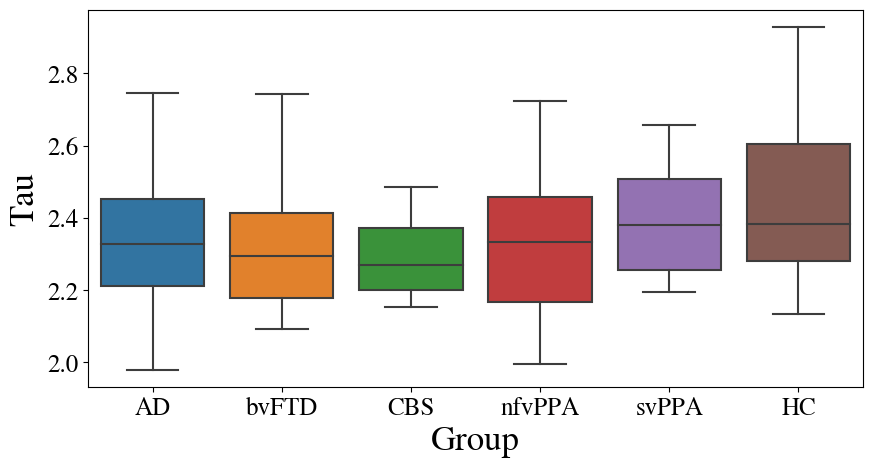

In [27]:
metric = "Tau"
metrics = np.array([res["fitted_theta"][1] for res in ress])
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
sns.boxplot(data=res_df, x="diagnosis1", y="metric", showfliers=False)
plt.xlabel("Group")
plt.ylabel(f"{metric}")
print(f"{metric} (time constant?)")
print(_get_test_tb(res_df))